---
# Examples of classifications using linear and quadratic discriminant analysis with a surface representation of the results
---

In this script, we show the differences in classification performances between the linear 
discriminant analysis (LDA) and the quadratic discriminant analysis (QDA) methods.

Both methods are applied to an "experimental" dataset generated  from a mixture of two 
gaussian probability distribution functions (PDF). Each one is weighted with its 
<i>a priori</i> class probability $P(C_{i})$:

<blockquote>  $P(\bf{x}) = P(\bf{x}|C_{1}) P(C_{1}) + P(\bf{x}|C_{2}) P(C_{2})$ </blockquote>


The discriminant methods are used to locate the influence zone of each class i over a 
spatial grid. This corresponds to regions where 

<blockquote> $P(\bf{x}|C_{i}) P(C_{i}) > P(\bf{x}|C_{j \ne i}) P(C_{j \ne i})$ </blockquote>

or 

<blockquote> $h_{i}(\bf{x}) > h_{j \ne i}(\bf{x})$ </blockquote>

with the discriminant function $h_{i}(\bf{x})$ defined as

<blockquote>  $h_{i}(\bf{x}) = \ln P(\bf{x}|C_{i}) P(C_{i})$ </blockquote>
<br><br>
 

## Quadratic Discriminant Analysis 
Using the matrix form of the 2-D gaussian PDF, we obtain:

<blockquote>  $h_{i}(\bf{x}) =\frac{1}{2}\ln |\Sigma_{i}| -\frac{1}{2}(\bf{x}-\bf{\mu_{i}})^\top \Sigma_{i}^{-1} (\bf{x}-\bf{\mu_{i}}) + \ln P(C_{i})$  </blockquote>

with 

<blockquote>  The observation:   $\bf{x}=[x_{1} x_{2}]^\top$ </blockquote> 

<blockquote>  The origin:   $\bf{\mu_{i}} = [\mu_{1} \mu_{2}]^\top$  </blockquote> 

<blockquote>  The covariance matrix: $\Sigma_{i} = \begin{pmatrix} \sigma_{x_{1}}^2 & \sigma_{x_{1,2}} \\ \sigma_{x_{1,2}} & \sigma_{x_{2}}^2 \end{pmatrix}$ </blockquote>
<br><br>

## Linear Discriminant Analysis 
The size of the experimental dataset has a large effect on the precision of the classification results. 
If we assume the covariance matrices to be identical (<i>homoscedasticity</i>), we have 
 $\Sigma _{i}=\Sigma$. The shared covariance matrix $\Sigma$ is computed as a weighted mixture of the individual ones:

<blockquote>  $\Sigma = \sum_{i=0}^{N} P(C_{i}) \Sigma_{i}$ </blockquote>

The new discriminant equations are $\bf{linear}$ and can be simplified to:
    
<blockquote>  $h_{i}(\bf{x}) = \bf{\mu_{i}}^\top \Sigma^{-1} \bf{x} - \frac{1}{2}\bf{\mu_{i}}^\top \Sigma^{-1} \bf{\mu_{i}} + \ln P(C_{i})$  </blockquote>


This is a useful approximation to make when the number of data points is small or the dimensionality of the data is high.
<br><br>



In [1]:
print(__doc__)

# Authors: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: XXX

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from skimage.transform import resize

from scipy import stats
from scipy.stats import multivariate_normal

from skimage.transform import resize

import math

import seaborn as sns; sns.set()

Automatically created module for IPython interactive environment


# Part I: Detailed example of a gaussian mixture with classification results
Parameters of the two gaussians PDF:

In [2]:
# For replicability
np.random.seed(42)

# Centers of the PDF
Mu = np.zeros((2,2))
Mu[0,:] = [6., 3.] # PDF 1
Mu[1,:] = [6., 7.] # PDF 2

# Standard deviations along the principal axes (sigma_PCA_1 >= sigma_PCA_2)
sigma = np.zeros((2,2))
sigma[0,:] = [2., 0.7] # PDF 1
sigma[1,:] = [1.2, 0.7] # PDF 2

# Rotation angles from the first principal axis
theta = np.array([-30., 0.]) # PDF 1 and PDF 2

# A priori class probabilities
prob_C = np.array([0.5, 0.5]) # PDF 1 and PDF 2


Compute the covariance matrix $\Sigma$ for the two gaussian PDF. 
The $\Sigma$ matrix is defined as:

<blockquote>  $\Sigma = \begin{pmatrix} \sigma_{x_{1}}^2 & \sigma_{x_{1,2}} \\ \sigma_{x_{1,2}} & \sigma_{x_{2}}^2 \end{pmatrix}$ </blockquote>

Instead of using trials and errors to guess the values of $\sigma_{x_{1}}$, $\sigma_{x_{2}}$ and $\sigma_{x_{1,2}}$, we use instead the following method. 
We select values of $\sigma_{PCA_{1}}$, $\sigma_{PCA_{2}}$ for an ellipsoid aligned with the x and y axis and an 
angle $\theta$ to rotate the axes. The following code generates the $\Sigma$ matrix.


In [3]:
n_PDF = 2
Sigma = np.zeros((2, 2, n_PDF))
for n in range(n_PDF):
    cov = np.zeros((2, 2))

    # Rotation matrix
    angle = np.radians(theta[n])
    c, s = np.cos(angle), np.sin(angle)
    R = np.array([[c, -s], [s, c]])

    # Covariance matrix for a PDF with its principal axes oriented along the x and y directions
    C = np.array([[sigma[n,0]**2, 0.],[0., sigma[n,1]**2]])

    # Covariance matrix after rotation
    Sigma[:,:,n] = R.dot(C.dot(R.T))
    

Generate a spatial grid where the PDF will be evaluated locally.

In [4]:
nx, ny = 300, 300
x_min, x_max = 0., 10.
y_min, y_max = 0., 10.

xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
pos = np.dstack((xx, yy)) 
Xgrid = np.c_[xx.ravel(), yy.ravel()]

Compute the global PDF as a sum of weighted PDF

In [5]:
model = multivariate_normal(Mu[0,:], Sigma[:,:,0]) 
pdf0 = prob_C[0]*model.pdf(pos)

model = multivariate_normal(Mu[1,:], Sigma[:,:,1]) 
pdf1 = prob_C[1]*model.pdf(pos)

pdf = pdf0 + pdf1

In [ ]:
Generate a dataset for the two PDF using the TRUE gaussian PDF parameters. This dataset is used as 
"experimental data" in what follows.

In [6]:
# Number of data points allocated to each PDF 
npts = 10000
n = (npts*prob_C).astype(int)

X0 = np.random.multivariate_normal(Mu[0], Sigma[:,:,0], n[0])        
X1 = np.random.multivariate_normal(Mu[1], Sigma[:,:,1], n[1])
X = np.r_[X0, X1]
y = np.hstack((np.zeros(n[0]), np.ones(n[1])))

Classification over the spatial grid using linear and quadratic discriminant analysis applied to the "experimental data". 

In [7]:
C = np.zeros([xx.shape[0], xx.shape[1], 2]).astype(bool)

# Method I: Linear Discriminant Analysis (LDA)
discriminant = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)  
C[:,:,0] = discriminant.fit(X, y).predict(Xgrid).reshape(xx.shape)

# Method II: Quadratic Discriminant Analysis (QDA)
discriminant = QuadraticDiscriminantAnalysis(store_covariance=True)
C[:,:,1] = discriminant.fit(X, y).predict(Xgrid).reshape(xx.shape)


## Show the global PDF in 3D with the influence zone of each class
N.B. There may be some slight mismatches between the overlying and underlying boundaries due to differences in resolution. 

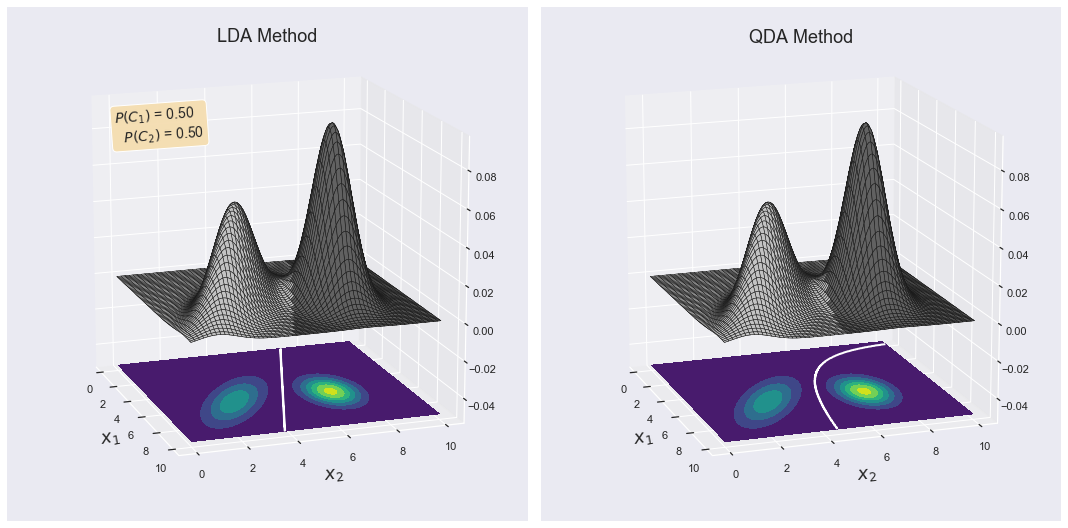

In [8]:
fig = plt.figure(figsize=(15,7.5), facecolor='white')


for i in range(2):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    # Generate OVERLYING 3-D surface with colors indicating the influence zone of each class
    rstride, cstride = 5, 5
    s = ax.plot_surface(xx, yy, pdf, rstride=rstride, cstride=cstride, linewidth=.5, antialiased=True, color='w', edgecolors='k')       
    a1 = s.__dict__['_original_facecolor']
    b1 = s.__dict__['_facecolors']
    c1 = s.__dict__['_facecolors3d']

    s = ax.plot_surface(xx, yy, pdf, rstride=rstride, cstride=cstride, linewidth=.5, antialiased=True, color='gray', edgecolors='k')
    a2 = s.__dict__['_original_facecolor']
    b2 = s.__dict__['_facecolors']
    c2 = s.__dict__['_facecolors3d']

    Lx = int(nx/rstride)
    Ly = int(ny/cstride)

    mask = resize(C[:,:,i], (Lx,Ly), order=0)
    indx = np.argwhere(mask)
    idx = indx[:,0]*Lx + indx[:,1]

    a = a1
    b = b1
    c = c1
    for j in idx:
        a[j,:] = a2[j,:]
        b[j,:] = b2[j,:]
        c[j,:] = c2[j,:]
    s.__dict__['_original_facecolor'] = a
    s.__dict__['_facecolors'] = b
    s.__dict__['_facecolors3d'] = c    


    # Generate UNDERLYING contours with borders between each class
    offset = -0.05
    cset = ax.contourf(xx, yy, pdf, zdir='z', offset=offset, cmap='viridis')

    # Display the boundary of the influence zone of each class
    ax.contour(xx, yy, C[:,:,i], [0.5], offset=offset, linewidths=2., colors='white') 

    ax.set_zlim(offset,np.max(pdf))

    view=[15.6, -19]
    ax.view_init(view[0], view[1])

    ax.set_ylabel('$x_{2}$', fontsize=18)
    ax.xaxis.set_rotate_label(False)  
    ax.set_xlabel('$x_{1}$', rotation=10, fontsize=18)
    
    z_max = pdf.max()
    if (i==0):
        text = '$P(C_{1})$ = %.2f \n  $P(C_{2})$ = %.2f' % (prob_C[0], prob_C[1])  
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.99)
        ax.text(0., 0., z_max, text, zdir='y', fontsize=14, verticalalignment='top', bbox=props)

        ax.set_title('LDA Method', fontsize=18)
    else:
        ax.set_title('QDA Method', fontsize=18)

    fig.tight_layout()


plt.savefig("Surface_classification_examples_with_LDA_and_QDA_methods_1.png", format="png")        

plt.show()


# Part II:   Various examples of gaussian mixtures with classification results. 
The following function contains most of the code in the previous cells; we use it to
display the classification results for each example.

In [9]:
def generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, figName, z_offset=-0.1, view=[15, -20]):
    
    #---------- Generate TRUE gaussian probability data distributions (PDF) ----------
    
    # Compute the covariance matrix Sigma for each gaussian PDF
    n_PDF = 2
    Sigma = np.zeros((2, 2, n_PDF))
    for n in range(n_PDF):
        cov = np.zeros((2, 2))

        # Rotation matrix
        angle = np.radians(theta[n])
        c, s = np.cos(angle), np.sin(angle)
        R = np.array([[c, -s], [s, c]])

        # Covariance matrix for a PDF with its principal axes oriented along the x and y directions
        C = np.array([[sigma[n,0]**2, 0.],[0., sigma[n,1]**2]])

        # Covariance matrix after rotation
        Sigma[:,:,n] = R.dot(C.dot(R.T))


    # Generate a spatial grid where the PDF will be evaluated locally.
    nx, ny = 300, 300
    xx, yy = np.meshgrid(np.linspace(0., 10., nx), np.linspace(0., 10., ny))
    pos = np.dstack((xx, yy)) 
    

    # Compute the global PDF as a sum of weighted PDF
    pdf = 0
    for n in range(n_PDF):
        model = multivariate_normal(Mu[n,:], Sigma[:,:,n]) 
        pdf +=prob_C[n]*model.pdf(pos)

        
    #------------- Generate datasets based on the estimated parameters of the TRUE distributions --------
    
    # Number of data points allocated to each PDF 
    npts = 10000
    n = (npts*prob_C).astype(int)

    X0 = np.random.multivariate_normal(Mu[0], Sigma[:,:,0], n[0])        
    X1 = np.random.multivariate_normal(Mu[1], Sigma[:,:,1], n[1])
    X = np.r_[X0, X1]
    y = np.hstack((np.zeros(n[0]), np.ones(n[1])))

    
    # ------ Classification using linear and quadratic discriminant analysis  ----------
    C = np.zeros([xx.shape[0], xx.shape[1], 2]).astype(bool)

    # Method I: Linear Discriminant Analysis (LDA)
    discriminant = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)  
    C[:,:,0] = discriminant.fit(X, y).predict(Xgrid).reshape(xx.shape)

    # Method II: Quadratic Discriminant Analysis (QDA)
    discriminant = QuadraticDiscriminantAnalysis(store_covariance=True)
    C[:,:,1] = discriminant.fit(X, y).predict(Xgrid).reshape(xx.shape)
    


    # -------------- Display the results ------------------------
    
    fig = plt.figure(figsize=(15,7.5), facecolor='white')


    for i in range(2):
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        # Generate OVERLYING 3-D surface with colors indicating the influence zone of each class
        rstride, cstride = 5, 5
        s = ax.plot_surface(xx, yy, pdf, rstride=rstride, cstride=cstride, linewidth=.5, antialiased=True, color='w', edgecolors='k')       
        a1 = s.__dict__['_original_facecolor']
        b1 = s.__dict__['_facecolors']
        c1 = s.__dict__['_facecolors3d']

        s = ax.plot_surface(xx, yy, pdf, rstride=rstride, cstride=cstride, linewidth=.5, antialiased=True, color='gray', edgecolors='k')
        a2 = s.__dict__['_original_facecolor']
        b2 = s.__dict__['_facecolors']
        c2 = s.__dict__['_facecolors3d']

        Lx = int(nx/rstride)
        Ly = int(ny/cstride)

        mask = resize(C[:,:,i], (Lx,Ly), order=0)
        indx = np.argwhere(mask)
        idx = indx[:,0]*Lx + indx[:,1]

        a = a1
        b = b1
        c = c1
        for j in idx:
            a[j,:] = a2[j,:]
            b[j,:] = b2[j,:]
            c[j,:] = c2[j,:]
        s.__dict__['_original_facecolor'] = a
        s.__dict__['_facecolors'] = b
        s.__dict__['_facecolors3d'] = c    


        # Generate UNDERLYING contours with borders between each class
        cset = ax.contourf(xx, yy, pdf, zdir='z', offset=z_offset, cmap='viridis')

        # Display the boundary of the influence zone of each class
        ax.contour(xx, yy, C[:,:,i], [0.5], offset=z_offset, linewidths=2., colors='white') 

        ax.set_zlim(z_offset,np.max(pdf))

        ax.view_init(view[0], view[1])

        ax.set_ylabel('$x_{2}$', fontsize=18)
        ax.xaxis.set_rotate_label(False)  
        ax.set_xlabel('$x_{1}$', rotation=10, fontsize=18)

        z_max = pdf.max()
        if (i==0):
            text = '$P(C_{1})$ = %.2f \n  $P(C_{2})$ = %.2f' % (prob_C[0], prob_C[1])  
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.99)
            ax.text(0., 0., z_max, text, zdir='y', fontsize=14, verticalalignment='top', bbox=props)

            ax.set_title('LDA Method', fontsize=18)
        else:
            ax.set_title('QDA Method', fontsize=18)

        fig.tight_layout()


    plt.savefig(figName, format="png")        

    plt.show()


### This series of 3 examples shows how the LDA and QDA boundaries are affected when the <i>a priori</i> class probabilities $P(C_{i})$ are varied.

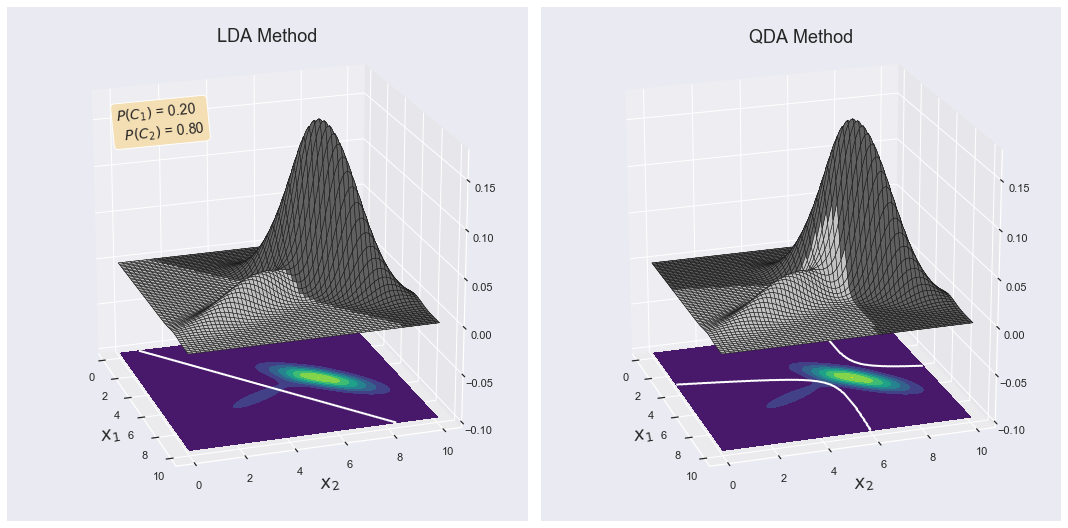

In [10]:
# For replicability
np.random.seed(42)

# Parameters of the two gaussians PDF
Mu = np.zeros((2,2))
Mu[0,:] = [6., 4.]
Mu[1,:] = [5., 7.]

sigma = np.zeros((2,2))
sigma[0,:] = [2., 0.5]
sigma[1,:] = [1.5, 0.5]

theta = np.array([-60., 45.]) 
prob_C = np.array([0.2, 0.8]) 

z_offset = -0.1

view = [21., -18]

figName = "Surface_classification_examples_with_LDA_and_QDA_methods_2.png"

generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, figName, z_offset=z_offset, view=view) 

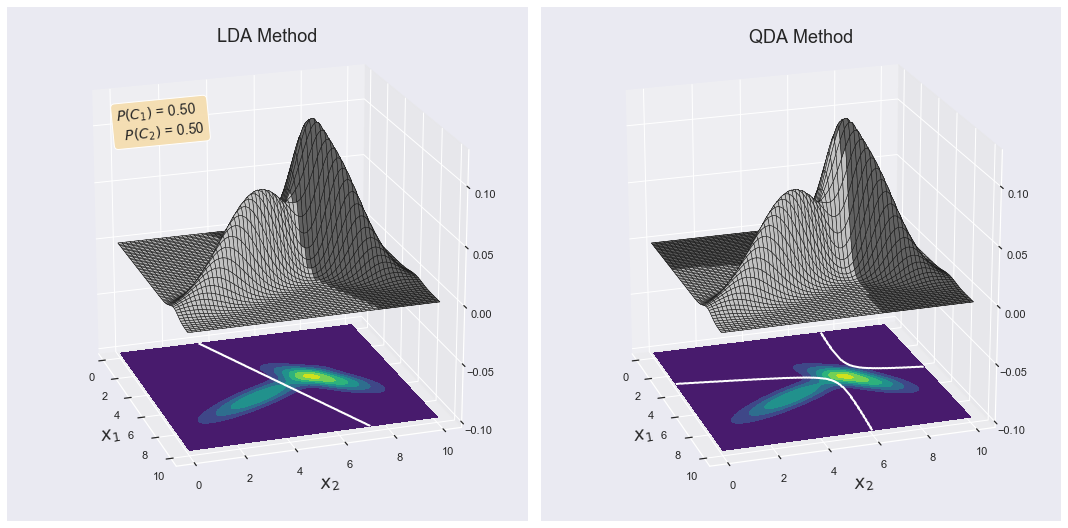

In [11]:
# For replicability
np.random.seed(42)

# Parameters of the two gaussians PDF
Mu = np.zeros((2,2))
Mu[0,:] = [6., 4.]
Mu[1,:] = [5., 7.]

sigma = np.zeros((2,2))
sigma[0,:] = [2., 0.5]
sigma[1,:] = [1.5, 0.5]

theta = np.array([-60., 45.]) 
prob_C = np.array([0.5, 0.5]) 

z_offset = -0.1

view = [21., -18]

figName = "Surface_classification_examples_with_LDA_and_QDA_methods_3.png"

generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, figName, z_offset=z_offset, view=view) 

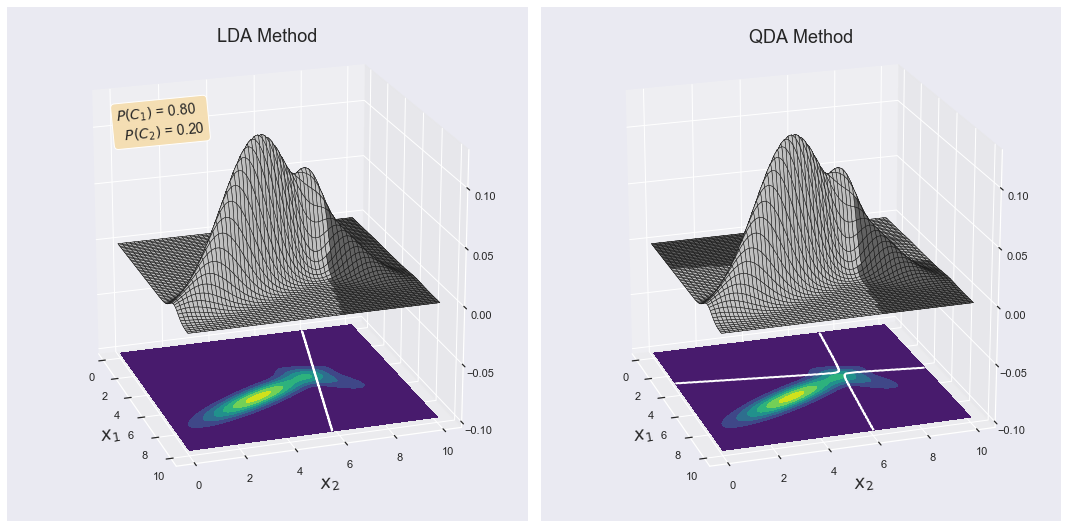

In [12]:
# For replicability
np.random.seed(42)

# Parameters of the two gaussians PDF
Mu = np.zeros((2,2))
Mu[0,:] = [6., 4.]
Mu[1,:] = [5., 7.]

sigma = np.zeros((2,2))
sigma[0,:] = [2., 0.5]
sigma[1,:] = [1.5, 0.5]

theta = np.array([-60., 45.]) 
prob_C = np.array([0.8, 0.2]) 

z_offset = -0.1

view = [21., -18]

figName = "Surface_classification_examples_with_LDA_and_QDA_methods_4.png"

generate_PDF_with_influences_zones(Mu, sigma, theta, prob_C, figName, z_offset=z_offset, view=view) 